In [16]:
import gensim.downloader as api
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy.spatial.distance import cosine

In [2]:
# Path configuration
DATA_DIR = Path('data')
TRAIN_PATH = DATA_DIR / 'train.csv'
# AUGMENTED_DATA_PATH = DATA_DIR / 'train_augmented.csv'
DEV_PATH = DATA_DIR / 'dev.csv'

In [3]:
train_data = pd.read_csv(TRAIN_PATH)

In [4]:
glove_embeddings = api.load('glove-wiki-gigaword-300')

In [5]:
def text_to_vec(text):
    # Split text into words and get vector for each word
    words = text.lower().split()
    
    word_vecs = [glove_embeddings[word] for word in words if word in glove_embeddings]
    
    if not word_vecs: return np.zeros(300)

    return np.mean(word_vecs, axis=0)

In [6]:
train_data['Claim Vectors'] = train_data['Claim'].apply(text_to_vec)
train_data['Evidence Vectors'] = train_data['Evidence'].apply(text_to_vec)

In [28]:
similarities = [1 - cosine(row['Claim Vectors'], row['Evidence Vectors']) for index, row in train_data.iterrows()]
similarities = np.array(similarities)
similarities = np.round(similarities, 2)

c:\Users\willi\Desktop\Uni\3rd_year\NLU\comp38412-not-broken\.venv\Lib\site-packages\scipy\spatial\distance.py:647: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / math.sqrt(uu * vv)


[0.74 0.7  0.54 ... 0.31 0.6  0.79]


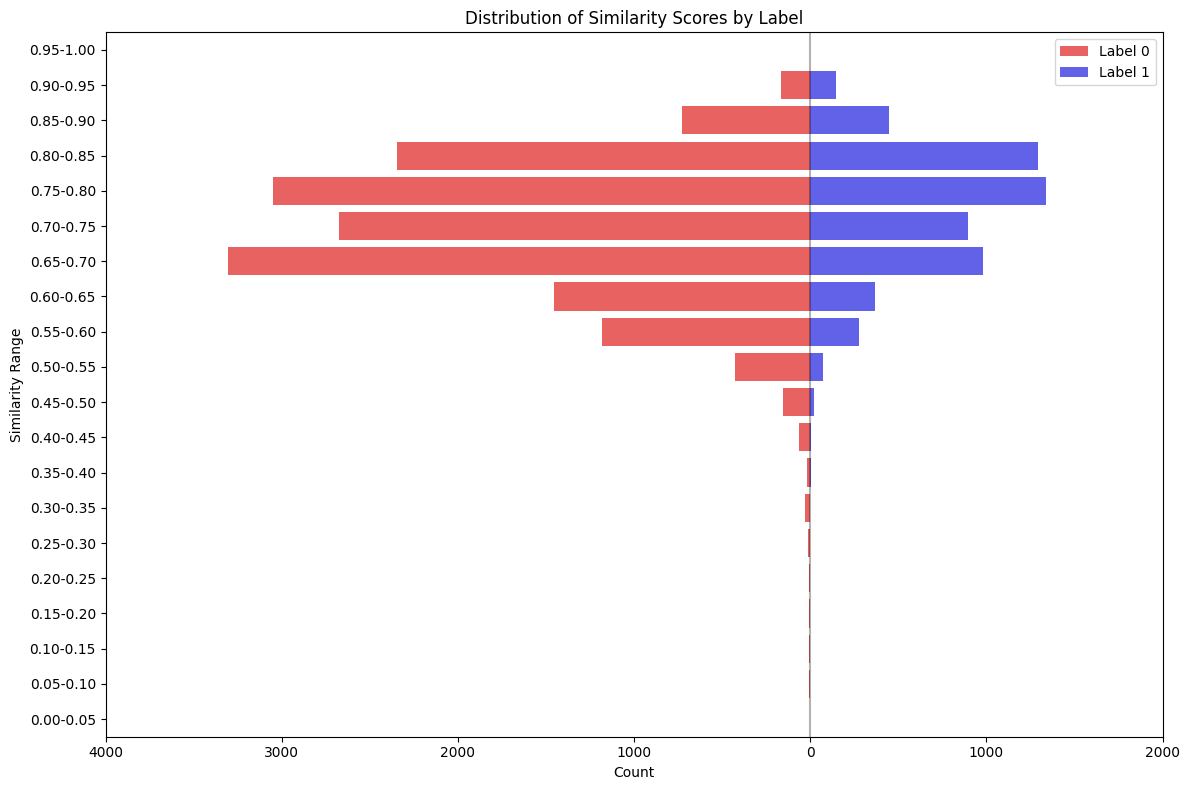

In [36]:
# Create bins for similarities
min_similarity = np.nanmin(similarities)
max_similarity = np.nanmax(similarities)
bins = np.arange(0, 1.01, 0.05)  # Create bins from 0 to 1 with step 0.05
bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]

label_0_similarities = []
label_1_similarities = []

for idx, similarity in enumerate(similarities):
    label = train_data.iloc[idx]['label']
    if label == 0:
        label_0_similarities.append(similarity)
    else:
        label_1_similarities.append(similarity)

# Count similarities in each bin for each label
label_0_hist, _ = np.histogram(label_0_similarities, bins=bins)
label_1_hist, _ = np.histogram(label_1_similarities, bins=bins)

# Create DataFrame for plotting
df = pd.DataFrame({
    'Similarity': bin_labels,
    'Label 0': -label_0_hist,  # Negative values for left side of pyramid
    'Label 1': label_1_hist    # Positive values for right side of pyramid
})

# Create the plot
plt.figure(figsize=(12, 8))

# Plot Label 0 (left side)
bar_plot = sns.barplot(x='Label 0', y='Similarity', data=df, 
                      color='red', alpha=0.7, label='Label 0')

# Plot Label 1 (right side)
bar_plot = sns.barplot(x='Label 1', y='Similarity', data=df, 
                      color='blue', alpha=0.7, label='Label 1')

bar_plot.set(xlabel="Count", 
            ylabel="Similarity Range", 
            title="Distribution of Similarity Scores by Label")

xticks = plt.xticks()[0]
plt.xticks(xticks, [abs(int(x)) for x in xticks])
# Add vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
# Invert the y-axis to have 0 at the bottom and 1 at the top
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

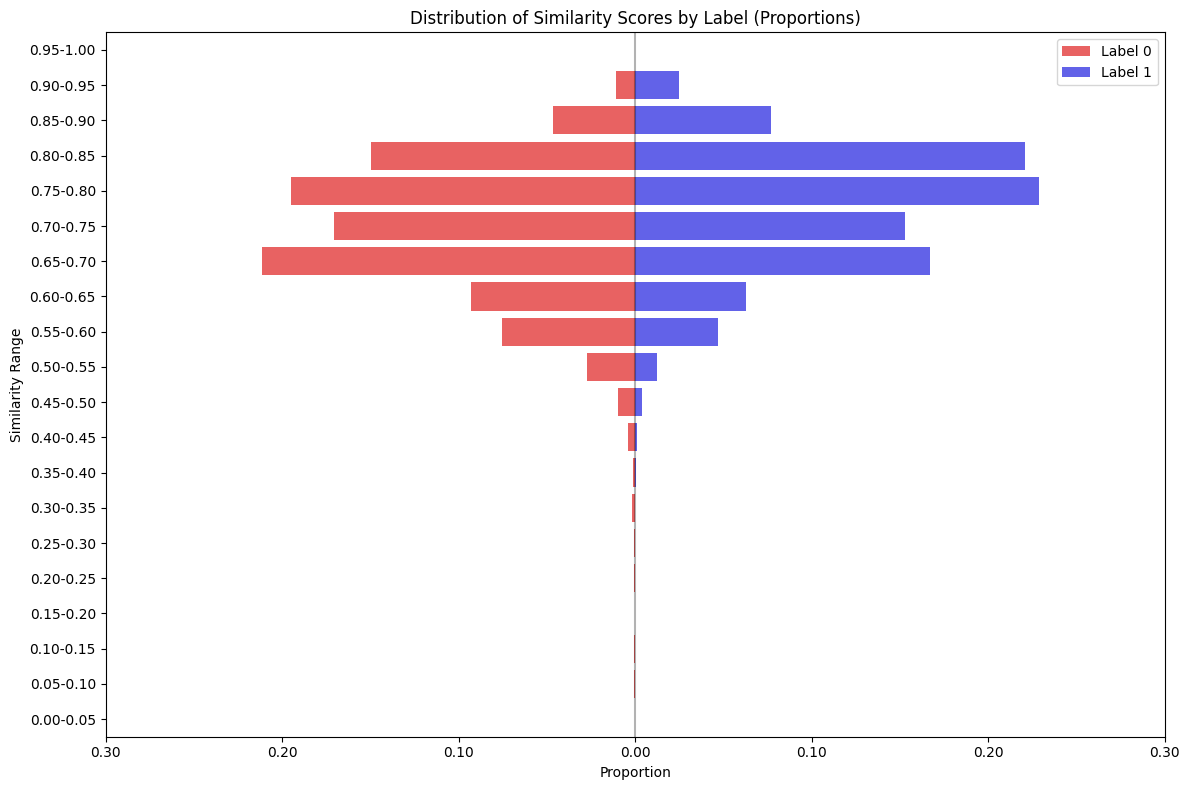

In [37]:
# Create bins for similarities
min_similarity = np.nanmin(similarities)
max_similarity = np.nanmax(similarities)
bins = np.arange(0, 1.01, 0.05)  # Create bins from 0 to 1 with step 0.05
bin_labels = [f'{bins[i]:.2f}-{bins[i+1]:.2f}' for i in range(len(bins)-1)]

label_0_similarities = []
label_1_similarities = []

for idx, similarity in enumerate(similarities):
    label = train_data.iloc[idx]['label']
    if label == 0:
        label_0_similarities.append(similarity)
    else:
        label_1_similarities.append(similarity)

# Count similarities in each bin for each label
label_0_hist, _ = np.histogram(label_0_similarities, bins=bins)
label_1_hist, _ = np.histogram(label_1_similarities, bins=bins)

# Calculate proportions instead of raw counts
total_label_0 = len(label_0_similarities)
total_label_1 = len(label_1_similarities)

# Convert to proportions
label_0_proportions = -label_0_hist / total_label_0  # Negative for left side
label_1_proportions = label_1_hist / total_label_1   # Positive for right side

# Create DataFrame for plotting
df = pd.DataFrame({
    'Similarity': bin_labels,
    'Label 0': label_0_proportions,  # Proportions for left side of pyramid
    'Label 1': label_1_proportions   # Proportions for right side of pyramid
})

# Create the plot
plt.figure(figsize=(12, 8))

# Plot Label 0 (left side)
bar_plot = sns.barplot(x='Label 0', y='Similarity', data=df, 
                      color='red', alpha=0.7, label='Label 0')

# Plot Label 1 (right side)
bar_plot = sns.barplot(x='Label 1', y='Similarity', data=df, 
                      color='blue', alpha=0.7, label='Label 1')

bar_plot.set(xlabel="Proportion", 
            ylabel="Similarity Range", 
            title="Distribution of Similarity Scores by Label (Proportions)")

# Format x-ticks to show absolute values with percentage format
xticks = plt.xticks()[0]
plt.xticks(xticks, [f'{abs(x):.2f}' for x in xticks])

# Add vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
# Invert the y-axis to have 0 at the bottom and 1 at the top
plt.gca().invert_yaxis()
plt.legend()
plt.tight_layout()
plt.show()

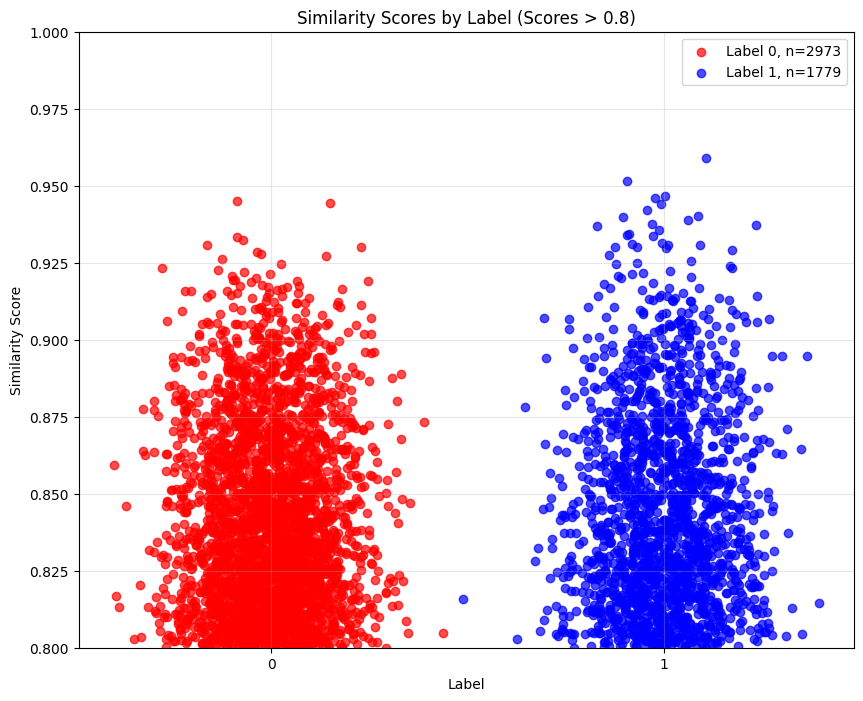

In [9]:
# Organize similarities by label
label_0_similarities = []
label_1_similarities = []

similarity_threshold = 0.80

for idx, similarity in enumerate(similarities):
    if similarity > similarity_threshold:
        label = train_data.iloc[idx]['label']
        if label == 0:
            label_0_similarities.append(similarity)
        else:
            label_1_similarities.append(similarity)

plt.figure(figsize=(10, 8))

# Add some jitter to the x positions
jitter_amount = 0.12
x_0 = np.zeros(len(label_0_similarities)) + np.random.normal(0, jitter_amount, len(label_0_similarities))
x_1 = np.ones(len(label_1_similarities)) + np.random.normal(0, jitter_amount, len(label_1_similarities))

# Plot points
plt.scatter(x_0, label_0_similarities, color='red', alpha=0.7, label=f'Label 0, n={len(label_0_similarities)}')
plt.scatter(x_1, label_1_similarities, color='blue', alpha=0.7, label=f'Label 1, n={len(label_1_similarities)}')

# Add labels and styling
plt.ylabel('Similarity Score')
plt.xlabel('Label')
plt.title(f'Similarity Scores by Label (Scores > {similarity_threshold})')
plt.xticks([0, 1], ['0', '1'])
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.0)  # Set y-axis limit to focus on the range of interest
plt.legend()
plt.show()

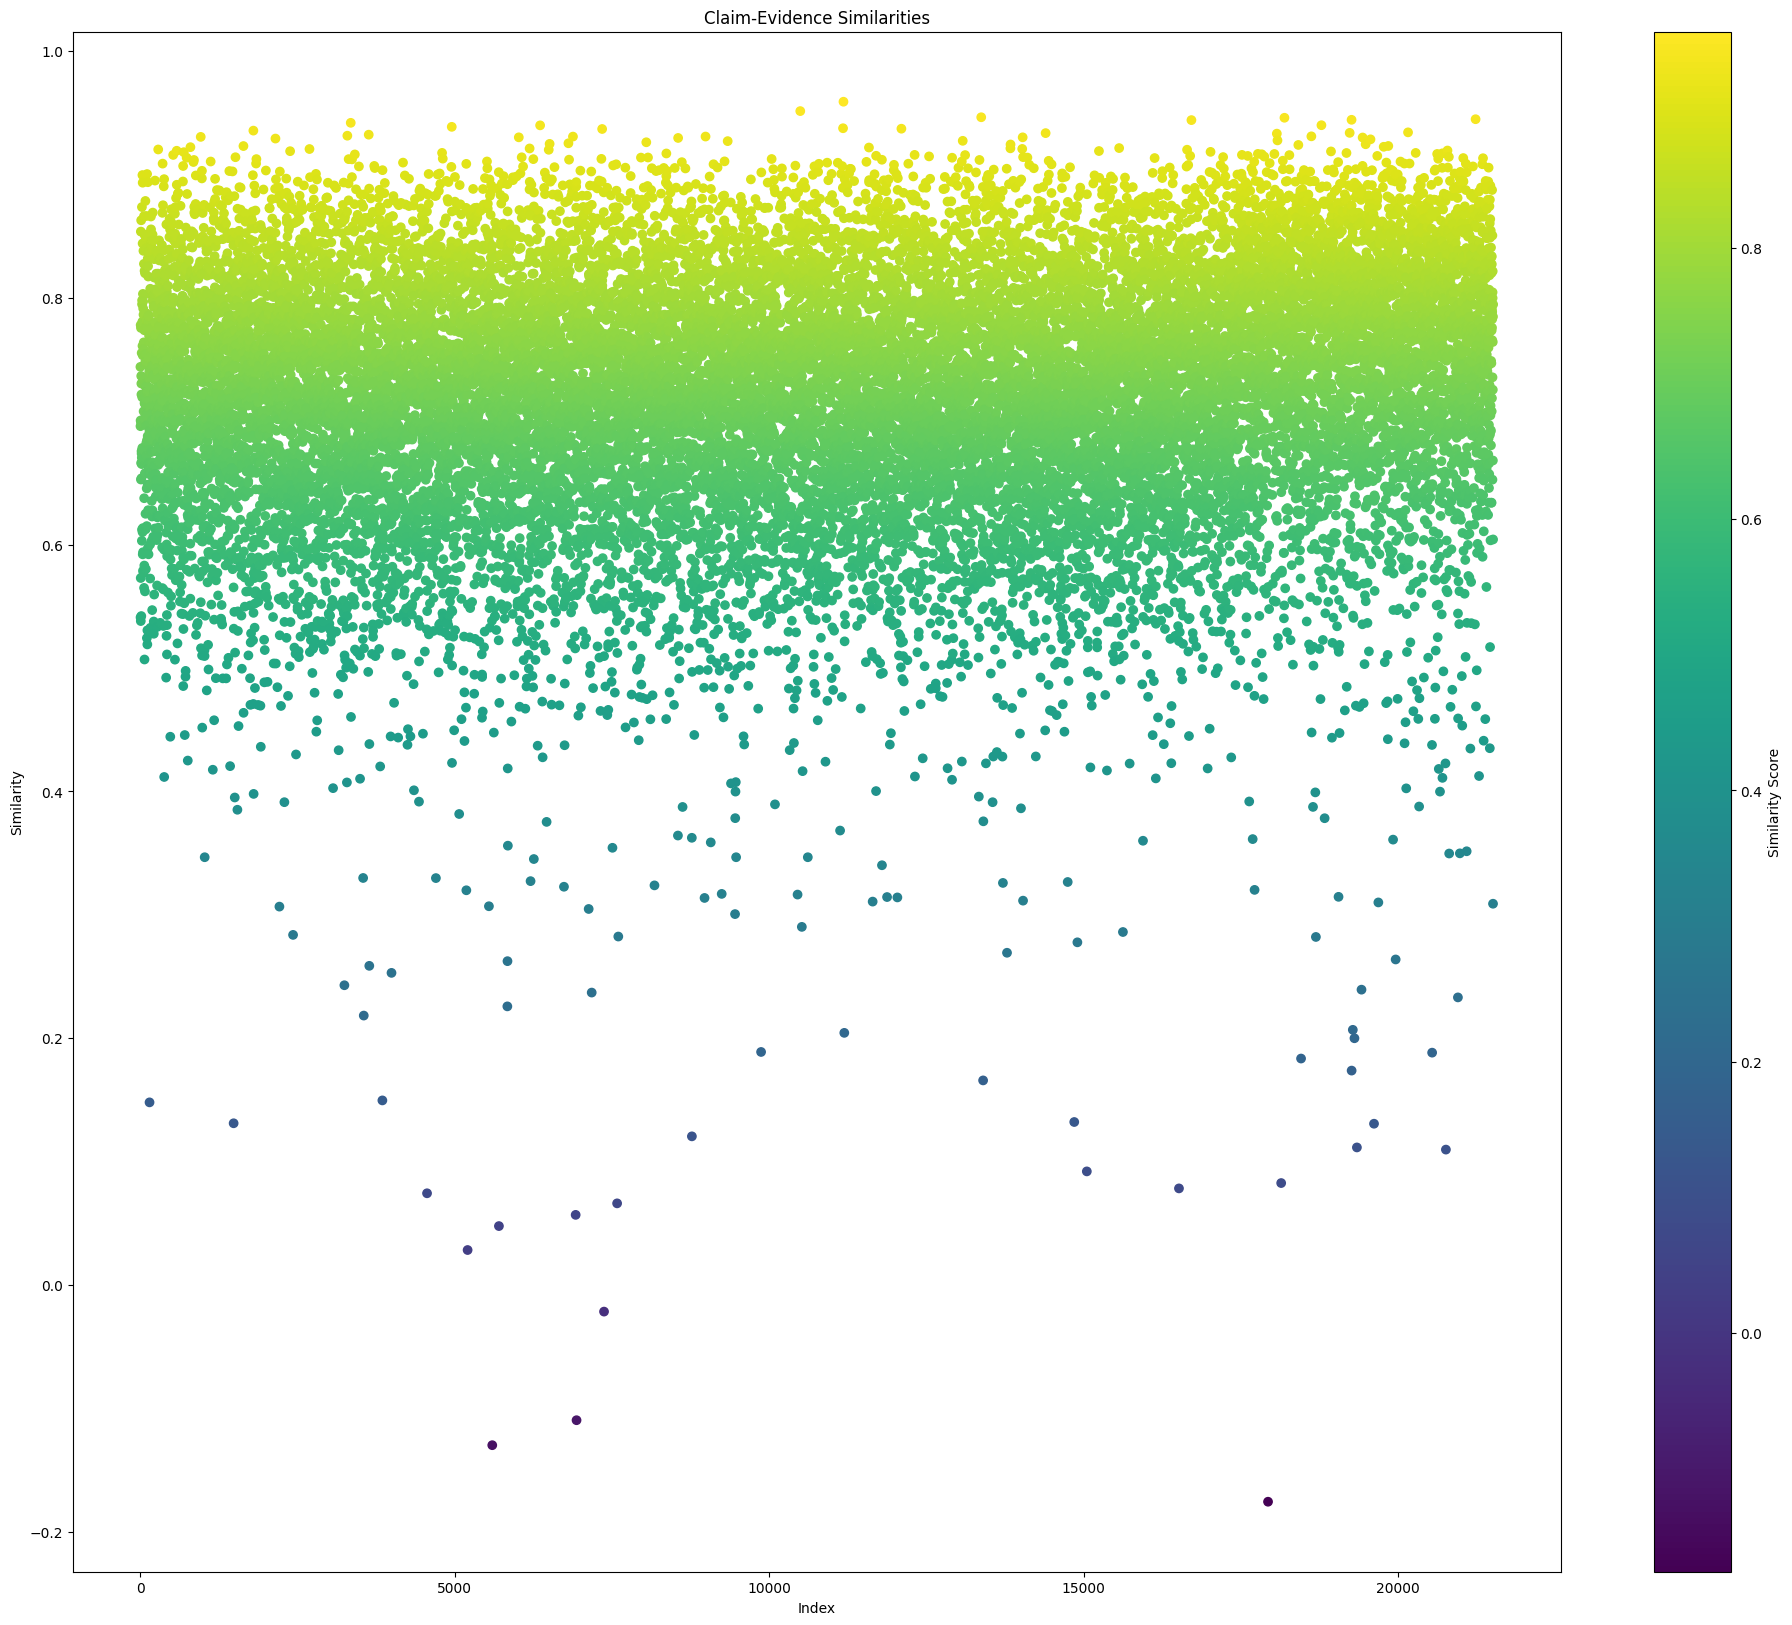

In [34]:
plt.figure(figsize=(24, 20))
plt.scatter(range(len(similarities)), similarities, c=similarities, cmap='viridis')
plt.colorbar(label='Similarity Score')
plt.title('Claim-Evidence Similarities')
plt.xlabel('Index')
plt.ylabel('Similarity')
plt.show()
